# Predicting (new) item categories

In this lab, we'll try to find a better way to categorize items than the categories they already have

First, we need to read in the items.csv and sales_train.csv files:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

items = pd.read_csv('./data/kaggle-sales/items.csv.gz')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [2]:
sales = pd.read_csv('./data/kaggle-sales/sales_train.csv.gz', parse_dates=['date'])
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


The only features we have for items right now is the description. Let's add some aggregate sales data mean_price and mean_volume. To do this, we'll first have to reformat sales data to be keyed by item_id and the year.

Follow a similar process to the feature engineering lab in order to do this.

In particular, we need to:

 - add a 'year' column
 - group by item_id and year, computing the (mean) price and (sum) txns
 - create a MultiIndex on item_id and year and reindex

In [3]:
sales['year'] = sales.date.dt.year
g = sales.groupby('item_id year'.split())
item_sales = pd.concat([
    g.item_price.mean().rename('price'),
    g.item_cnt_day.sum().rename('txns'),
], axis=1)
item_sales.head()

,,price,txns
item_id,year,,
0,2014,58.0,1.0
1,2014,4490.0,6.0
2,2014,58.0,2.0
3,2014,79.0,2.0
4,2014,58.0,1.0


In [4]:
index = pd.MultiIndex.from_product(
    [
        sorted(sales['item_id'].unique()),
        np.r_[sales['year'].min(): sales['year'].max() + 1]
    ], names=['item_id', 'year']
)
item_sales = item_sales.reindex(index)
item_sales.head()

price  txns
item_id year              
0       2013     NaN   NaN
        2014    58.0   1.0
        2015     NaN   NaN
1       2013     NaN   NaN
        2014  4490.0   6.0

Fill missing txns with 0:

In [5]:
item_sales = item_sales.fillna({'txns': 0})
item_sales.head()

price  txns
item_id year              
0       2013     NaN   0.0
        2014    58.0   1.0
        2015     NaN   0.0
1       2013     NaN   0.0
        2014  4490.0   6.0

Now we can calculate the mean price and mean transactions per year by grouping *only* by item_id and aggregating with mean:

In [7]:
np.mean

<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>

In [8]:
np.nanmean

<function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>

In [6]:
item_sales = item_sales.groupby(level=0).mean()
item_sales.head()

,price,txns
item_id,,
0,58.0,0.333333
1,4490.0,2.000000
2,58.0,0.666667
3,79.0,0.666667
4,58.0,0.333333


Create an item_features dataframe that includes the name, price, and transactions:

In [9]:
data = pd.merge(items, item_sales, left_on='item_id', right_index=True)
data.head()

,item_name,item_id,item_category_id,price,txns
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,58.0,0.333333
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,4490.0,2.000000
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,58.0,0.666667
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,79.0,0.666667
4,***КОРОБКА (СТЕКЛО) D,4,40,58.0,0.333333


Now we'll encode our text features as before:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer()
transformer = TfidfTransformer()

text_features = vectorizer.fit_transform(data.item_name)
text_features = transformer.fit_transform(text_features)
text_features

<21807x18029 sparse matrix of type '<class 'numpy.float64'>'
	with 123111 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10)
truncated_text_features = svd.fit_transform(text_features)

Finally, we create our features dataframe with:

- price
- txns
- text features

In [12]:
features = pd.concat([
    data['price txns'.split()],
    pd.DataFrame(truncated_text_features, columns=[f'text_{i}' for i in range(10)])
], axis=1)
features.head()

,price,txns,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9
0,58.0,0.333333,0.000661,0.000146,6.616174e-04,-0.000094,0.000295,-0.000529,-0.000382,-0.000288,0.001571,0.000424
1,4490.0,2.000000,0.298564,-0.011867,-5.074774e-02,-0.097134,-0.005300,0.031980,0.005914,0.007494,-0.079531,0.047712
2,58.0,0.666667,0.000003,0.000004,-7.056422e-07,-0.000007,0.000005,0.000001,-0.000004,-0.000006,-0.000004,0.000008
3,79.0,0.666667,0.000145,0.000581,9.338855e-04,-0.000040,0.000681,0.000309,0.000537,-0.000118,0.000848,0.001530
4,58.0,0.333333,0.001330,0.000328,1.089046e-03,0.000043,0.000048,0.000560,0.000499,-0.002243,-0.002676,0.007748


## Scaling 

Use a StandardScaler to scale the features

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = pd.DataFrame(
    scaler.fit_transform(features),
    columns=features.columns
)

features_scaled.head()

,price,txns,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9
0,-0.270629,-0.121722,-0.567608,-0.366381,-0.246894,-0.060270,-0.266198,-0.198055,-0.149527,0.111609,-0.122154,-0.171912
1,1.325167,-0.118062,2.509481,-0.508676,-0.903923,-1.302973,-0.341579,0.320933,-0.047383,0.243074,-1.551444,0.717037
2,-0.270629,-0.120990,-0.574407,-0.368067,-0.255359,-0.059155,-0.270108,-0.189594,-0.143399,0.116365,-0.149906,-0.179734
3,-0.263067,-0.120990,-0.572940,-0.361231,-0.243414,-0.059578,-0.261005,-0.184681,-0.134626,0.114481,-0.134895,-0.151113
4,-0.270629,-0.121722,-0.560696,-0.364234,-0.241431,-0.058516,-0.269525,-0.180679,-0.135232,0.078580,-0.196993,-0.034222


# Use DBSCAN with eps=0.1 to find a clustering

In [14]:
from sklearn import cluster

X = features_scaled.dropna()
dbscan = cluster.DBSCAN(eps=0.1)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [15]:
len(np.unique(dbscan.labels_))

128

In [18]:
len(items.item_category_id.unique())

84

# Interpreting results

Use a RandomForestClassifier to evaluate feature importance for the clustering chosen. 

Remember to drop any sample with a cluster of -1

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc_data = pd.concat([X, pd.Series(dbscan.labels_, index=X.index, name='cluster')], axis=1)

In [20]:
rfc_data = rfc_data[rfc_data.cluster >= 0]

X1 = rfc_data[rfc_data.columns[:-1]]
y1 = rfc_data[rfc_data.columns[-1]]

In [21]:
rfc = RandomForestClassifier()
rfc.fit(X1, y1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Create a plot of the feature importance from the classifier

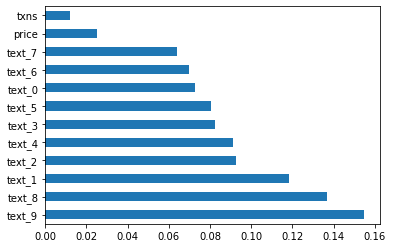

In [22]:
(
    pd.Series(rfc.feature_importances_, index=X1.columns)
    .sort_values(ascending=False)
    .plot.barh()
)

# Analyzing with a RandomForestRegressor

One of the things we might like to know is how predictive of the # of transactions each of our item features is. For this, we can train a RandomForestRegressor and get its feature_importances.

Train a RandomForestRegressor on the feature data, using txns as the target column

In [23]:
X2 = features_scaled.copy().dropna()
y2 = X2.pop('txns')
X2.head()

,price,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9
0,-0.270629,-0.567608,-0.366381,-0.246894,-0.060270,-0.266198,-0.198055,-0.149527,0.111609,-0.122154,-0.171912
1,1.325167,2.509481,-0.508676,-0.903923,-1.302973,-0.341579,0.320933,-0.047383,0.243074,-1.551444,0.717037
2,-0.270629,-0.574407,-0.368067,-0.255359,-0.059155,-0.270108,-0.189594,-0.143399,0.116365,-0.149906,-0.179734
3,-0.263067,-0.572940,-0.361231,-0.243414,-0.059578,-0.261005,-0.184681,-0.134626,0.114481,-0.134895,-0.151113
4,-0.270629,-0.560696,-0.364234,-0.241431,-0.058516,-0.269525,-0.180679,-0.135232,0.078580,-0.196993,-0.034222


In [26]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_jobs=-1, verbose=1)
rfr.fit(X2, y2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

Create a plot of the feature importance from the regressor

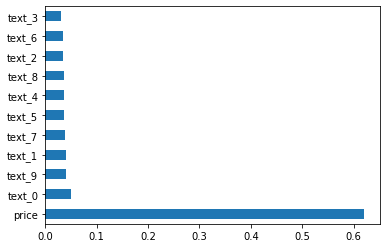

In [27]:
(
    pd.Series(rfr.feature_importances_, index=X2.columns)
    .sort_values(ascending=False)
    .plot.barh()
)